Written by Joao Rodrigues

June 2020

Example: Implements a simple, spatially resolved, 2D harmonic oscillator and calculates the steady-state populations and a function of increasing pump power. The idea is to show the occurence of BEC phase transition, and eventually other phase transitions.

Note: All parameters are defined in SI units


In [225]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

## Calculates the cavity modes for a spherical mirror

In [226]:
grid_size = 60.0*1e-6      # meters
grid_delta = 2*1e-6      # meters 
L0 = 2.0*1e-6              # meters 
q = 10                     # longitudinal mode number
#n = 2.4
n=1.43
n_modes = 50
feature_RoC = 0.1   # meters
feature_depth = 0.279*1e-6 # meters

from PyPBEC.Cavity import Modes
cavity_modes = Modes(grid_size=grid_size, grid_delta=grid_delta, L0=L0, q=q, n=n, n_modes=n_modes)
cavity_modes.set_geometry_elliptical(RoC=feature_RoC, depth=feature_depth, anistropy_factor=1.001)
lambdas, modes = cavity_modes.compute_cavity_modes()
g = cavity_modes.get_coupling_matrix()
print(lambdas)

[5.71919347e-07 5.71839490e-07 5.71839412e-07 5.71761142e-07
 5.71760989e-07 5.71759577e-07 5.71684348e-07 5.71684122e-07
 5.71681251e-07 5.71681176e-07 5.71609157e-07 5.71608862e-07
 5.71604478e-07 5.71604331e-07 5.71602871e-07 5.71535623e-07
 5.71535264e-07 5.71529308e-07 5.71529092e-07 5.71526120e-07
 5.71526048e-07 5.71463809e-07 5.71463388e-07 5.71455795e-07
 5.71455514e-07 5.71450970e-07 5.71450829e-07 5.71449317e-07
 5.71393785e-07 5.71393307e-07 5.71384001e-07 5.71383658e-07
 5.71377477e-07 5.71377271e-07 5.71374187e-07 5.71374119e-07
 5.71325630e-07 5.71325100e-07 5.71313996e-07 5.71313596e-07
 5.71305703e-07 5.71305435e-07 5.71300714e-07 5.71300580e-07
 5.71299009e-07 5.71259438e-07 5.71258859e-07 5.71245861e-07
 5.71245408e-07 5.71235717e-07]


## Defines the cavity pump profile

In [227]:
pump_width = 10*1e-6       # meters

X, Y = cavity_modes.get_cavity_grid()
pump_base = np.exp(-((X)**2+(Y)**2) / pump_width**2)
pump = 1*(pump_base/np.sum(pump_base))
cavity_modes.load_pump(pump=pump)

## Plots the cavity modes and the pump profile

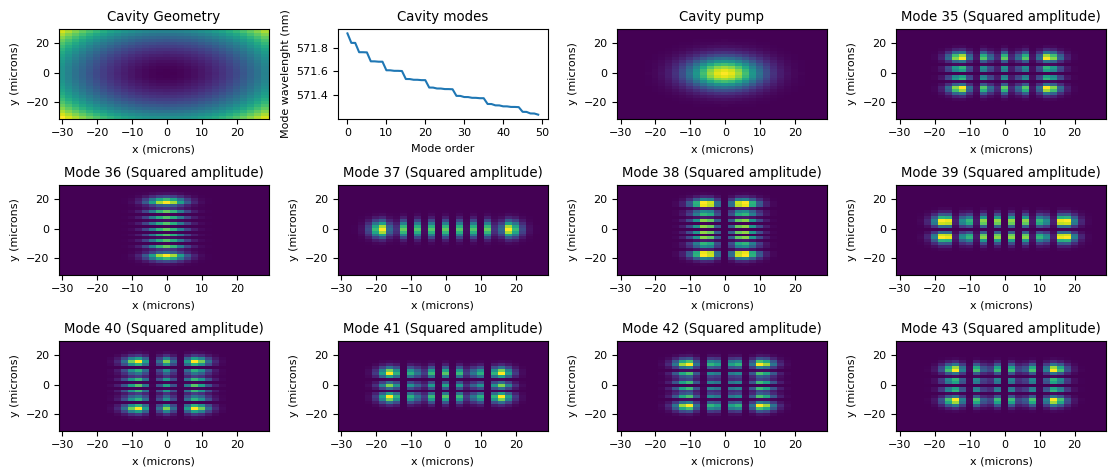

In [228]:
cavity_modes.plot_cavity(start_mode=35)


## Calculates emission and absorption rates from experimental data

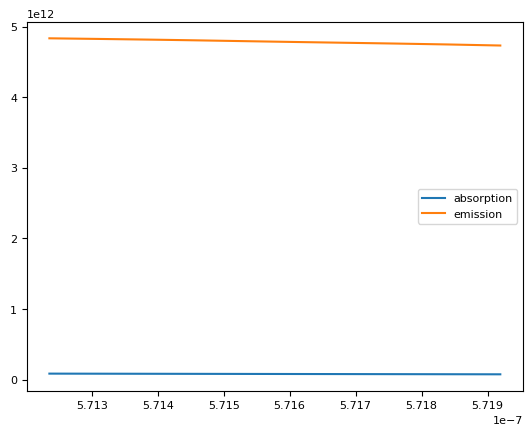

In [229]:
dye_concentration = 2.0               # in mM, with 1 mM=1mol/m^3

from PyPBEC.OpticalMedium import OpticalMedium
#R6G = OpticalMedium(optical_medium="InGaAs_QW")
#absorption_rates, emission_rates = R6G.get_rates(lambdas=lambdas, mode=17)

R6G = OpticalMedium(optical_medium="Rhodamine6G")
absorption_rates, emission_rates = R6G.get_rates(lambdas=lambdas, dye_concentration=dye_concentration, n=n)

plt.plot(lambdas, absorption_rates, label='absorption')
plt.plot(lambdas, emission_rates, label='emission')
plt.legend()
plt.show()

#### Normalizes the rates, for better numerical performance

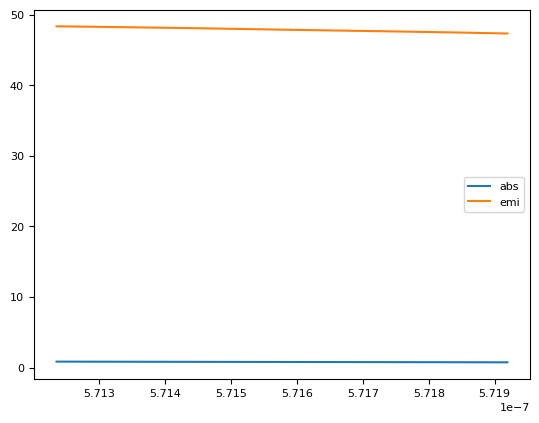

In [230]:
cavity_loss_rate = 1.0/(10*1e-12)     # in s^-1
#cavity_loss_rate = 20     # in s^-1



cavity_loss_rates = np.ones(n_modes)
emission_rates = emission_rates / (cavity_loss_rate)
absorption_rates = absorption_rates / cavity_loss_rate

plt.plot(lambdas, absorption_rates, label = 'abs')
plt.plot(lambdas, emission_rates, label = 'emi')
plt.legend()
plt.show()

## Defines a cavity

In [231]:
Gamma_down = 100.0
#Gamma_down = cavity_loss_rate/4

# Properties of the photonic modes
from PyPBEC.Cavity import Cavity
cavity = Cavity(M=n_modes, J=g.shape[1])
cavity.set_cavity_loss_rates(rates=cavity_loss_rates)
cavity.set_cavity_emission_rates(rates=emission_rates)
cavity.set_cavity_absorption_rates(rates=absorption_rates)

# Properties of the molecular modes
cavity.set_reservoir_decay_rates(rates=Gamma_down*np.ones(g.shape[1]))
cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))
molecular_population = np.array(sc.Avogadro*dye_concentration*(0.5*L0*grid_delta**2)*np.ones(g.shape[1]), dtype=int)
cavity.set_reservoir_population(population=molecular_population)

# Coupling between photonic and molecular modes
cavity.set_coupling_terms(coupling_terms=g)


## Creates the array of pump values

In [232]:
pump_value_min = 100.0
pump_value_max = 1000000.0
n_pump_values = 30

delta_p = (pump_value_max/pump_value_min)**(1/n_pump_values)-1
pumps = [(1+delta_p)**i*pump_value_min for i in range(0, n_pump_values)]

## Solves the mean-field steady-state

In [233]:
from PyPBEC.Solver import SteadyState
from tqdm import tqdm
from Semiconductor_func import degeneracy_sum

populations = list()
for value in tqdm(pumps):
    # loads the pump onto the cavity object
    pump = value*(pump_base/np.sum(pump_base))
    cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))
    
    # Steady-state solver
    solver_steadystate = SteadyState(cavity_obj=cavity, ANNEALING=False)
    # Defines the initial guess
    if value==pumps[0]:
        solver_steadystate.set_initial_photons(initial_photons=np.array(np.zeros(cavity.M)))
        solver_steadystate.set_initial_excited_molecules(initial_excited_molecules=np.array(np.zeros(cavity.J)))  
    else:
        solver_steadystate.set_initial_photons(initial_photons=np.array(solved_cavity_steadystate.photons[-1]))
        solver_steadystate.set_initial_excited_molecules(initial_excited_molecules=np.array(solved_cavity_steadystate.emols[-1])) 
    
    # Calls the solver
    solved_cavity_steadystate = solver_steadystate.solve()
    
    # Sums the populations over the mode degeneracy, g=n+1, with n=0,1,2,...
    mode_degeneracy = np.array([j for j in range(0, n_modes) for i in range(0, j)][0:n_modes])
    steady_state_photon_population = [np.sum(solved_cavity_steadystate.photons[:,np.where(mode_degeneracy==mode_number)[0]], 1) 
        for mode_number in list(set(list(mode_degeneracy)))]
    steady_state_photon_population = np.transpose(np.array(steady_state_photon_population))
    
    # mode_degeneracy = 2*np.ones(n_modes)
    # mode_degeneracy[0] = 1
    # mode_degeneracy[5] = 1
    # mode_degeneracy[27] = 1
    # 
    # steady_state_photon_population = degeneracy_sum(mode_degeneracy, solved_cavity_steadystate.photons)
    # 
    # steady_state_photon_population = np.abs(steady_state_photon_population)

    
    # Appends
    populations.append(steady_state_photon_population)
populations = np.array(populations)

100%|██████████| 30/30 [07:54<00:00, 15.82s/it]


## Plots the results

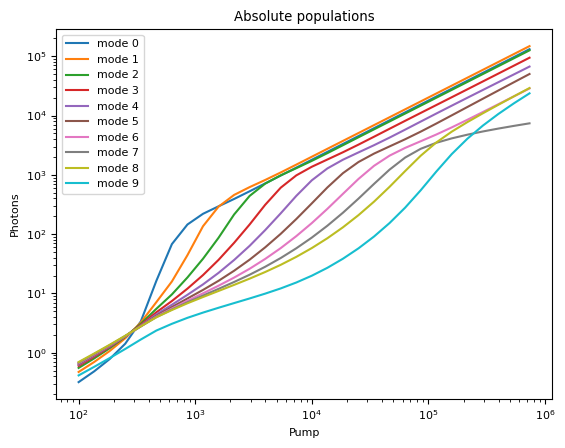

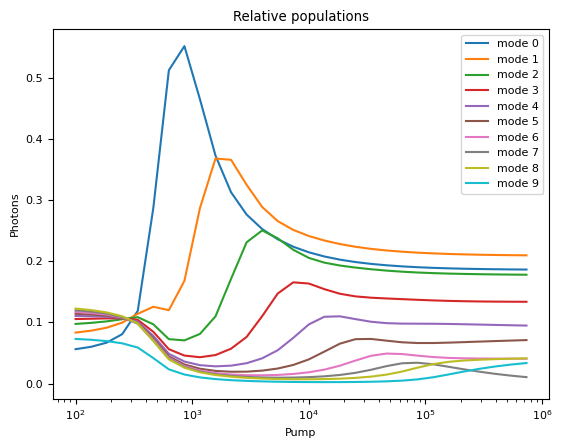

In [234]:
populations = np.squeeze(populations)

[plt.plot(pumps, populations[:,i], label="mode {0}".format(i)) for i in range(0, populations.shape[1])]
plt.legend()
plt.xlabel("Pump")
plt.xscale("log")
plt.ylabel("Photons")
plt.yscale("log")
plt.title("Absolute populations")
plt.show()

[plt.plot(pumps, populations[:,i]/np.sum(populations,1), label="mode {0}".format(i)) for i in range(0, populations.shape[1])]
plt.legend()
plt.xlabel("Pump")
plt.xscale("log")
plt.ylabel("Photons")
plt.title("Relative populations")
plt.show()